In [ ]:
!pip3 install bitmex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import bitmex
import json
import requests
import time
import math
import os.path
import xgboost as xgb
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook
from datetime import timedelta, datetime
from dateutil import parser

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
bitmex_api_key = "NC_0TmtRCIeIuE52qx_W2Zjp"
bitmex_api_secret = "d8wM1lMbtZmyDiFBmXBozHnBpa6rXA_Wdre-Rk2gBVAr5i-t"
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
bitmex_client = bitmex.bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)
binSize='1h'
past_minute_data = bitmex_client.Trade.Trade_getBucketed(binSize=binSize, count=1000, symbol='XBTUSD', reverse=True)

/usr/local/lib/python3.8/dist-packages/swagger_spec_validator/validator20.py:49: SwaggerValidationWarning:

Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)



In [ ]:
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

In [ ]:
def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [ ]:
data_df = get_all_bitmex("XBTUSD", "1d", save=True)


All caught up..!


In [ ]:

#Loading dataset
data=pd.read_csv("/content/XBTUSD-1d-data.csv")


In [ ]:
data.head()

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
0,2015-09-26 00:00:00+00:00,XBTUSD,239.99,239.99,234.81,235.20,153,190090,235.910,24,44844188670,448.441887,105792.660735
1,2015-09-27 00:00:00+00:00,XBTUSD,235.20,235.36,232.91,234.51,146,258488,233.990,200,60483729840,604.837298,141526.710902
2,2015-09-28 00:00:00+00:00,XBTUSD,234.51,234.76,233.03,233.29,101,161013,233.550,1000,37604645900,376.046459,87825.998859
3,2015-09-29 00:00:00+00:00,XBTUSD,233.29,243.19,232.90,240.07,262,319143,237.981,50,75949944400,759.499444,180755.759328
4,2015-09-30 00:00:00+00:00,XBTUSD,240.07,241.50,235.81,237.00,285,368771,238.266,9000,87865511830,878.655118,209360.657739


In [ ]:
data.tail()

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
2677,2023-01-24 00:00:00+00:00,XBTUSD,22697.5,23175.0,22478.5,22910.5,90690,374543500,22842.5236,800,1639680118808,16396.801188,374543500.0
2678,2023-01-25 00:00:00+00:00,XBTUSD,22910.5,23154.5,22454.0,22629.5,84334,360087600,22908.8252,200,1571830532639,15718.305326,360087600.0
2679,2023-01-26 00:00:00+00:00,XBTUSD,22629.5,23903.0,22333.5,23055.0,103571,502615700,22894.9260,100,2195315715447,21953.157154,502615700.0
2680,2023-01-27 00:00:00+00:00,XBTUSD,23055.0,23277.5,22847.5,23004.0,79884,361910300,23051.2475,200,1570025774662,15700.257747,361910300.0
2681,2023-01-28 00:00:00+00:00,XBTUSD,23004.0,23499.5,22525.0,23068.0,107087,709014500,23046.9974,100,3076389320783,30763.893208,709014500.0


In [ ]:
data.shape

(2682, 13)

In [ ]:
data.describe()

,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
count,2682.000000,2682.000000,2682.000000,2682.000000,2.682000e+03,2.682000e+03,2682.000000,2682.000000,2.682000e+03,2.682000e+03,2.682000e+03
mean,14655.101928,15072.909045,14182.165075,14663.613490,2.832812e+05,1.339882e+09,14634.529712,3989.196122,1.382892e+13,1.382892e+05,1.339937e+09
std,16462.991676,16921.607215,15927.979033,16461.437215,3.099033e+05,1.440406e+09,16433.028549,12174.277543,1.808942e+13,1.808942e+05,1.440355e+09
min,233.290000,234.760000,232.900000,233.290000,6.200000e+01,1.121120e+05,233.550000,1.000000,3.044369e+10,3.044369e+02,7.274309e+04
25%,2783.425000,2888.750000,2654.600000,2795.075000,4.883475e+04,1.175454e+08,2760.657875,100.000000,1.591061e+12,1.591061e+04,1.175454e+08
50%,8276.250000,8532.250000,8065.750000,8288.750000,1.862640e+05,9.731138e+08,8314.977450,500.000000,5.314941e+12,5.314941e+04,9.731138e+08
75%,19529.625000,20039.625000,19075.000000,19538.750000,4.243560e+05,2.075523e+09,19489.793025,3000.000000,2.165497e+13,2.165497e+05,2.075523e+09
max,67642.000000,69146.500000,66289.500000,67642.000000,3.661752e+06,1.362211e+10,67545.660900,222304.000000,1.673668e+14,1.673668e+06,1.362211e+10


In [ ]:
data.isnull().sum()

timestamp          0
symbol             0
open               0
high               0
low                0
close              0
trades             0
volume             0
vwap               0
lastSize           0
turnover           0
homeNotional       0
foreignNotional    0
dtype: int64

In [ ]:
data['timestamp'] = pd.to_datetime(data.timestamp)
data.head()

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
0,2015-09-26 00:00:00+00:00,XBTUSD,239.99,239.99,234.81,235.20,153,190090,235.910,24,44844188670,448.441887,105792.660735
1,2015-09-27 00:00:00+00:00,XBTUSD,235.20,235.36,232.91,234.51,146,258488,233.990,200,60483729840,604.837298,141526.710902
2,2015-09-28 00:00:00+00:00,XBTUSD,234.51,234.76,233.03,233.29,101,161013,233.550,1000,37604645900,376.046459,87825.998859
3,2015-09-29 00:00:00+00:00,XBTUSD,233.29,243.19,232.90,240.07,262,319143,237.981,50,75949944400,759.499444,180755.759328
4,2015-09-30 00:00:00+00:00,XBTUSD,240.07,241.50,235.81,237.00,285,368771,238.266,9000,87865511830,878.655118,209360.657739


In [ ]:
print("Starting date: ",data.iloc[0][0])
print("Ending date: ", data.iloc[-1][0])
print("Duration: ", data.iloc[-1][0]-data.iloc[0][0])

Starting date:  2015-09-26 00:00:00+00:00
Ending date:  2023-01-28 00:00:00+00:00
Duration:  2681 days 00:00:00


In [ ]:
#EDA
#Visualizing dataset for 2015
y_2015 = data.loc[(data['timestamp'] >= '2015-01-01')
                     & (data['timestamp'] < '2016-01-01')]

y_2015.drop(y_2015[['trades','volume','vwap','lastSize', 'turnover', 'homeNotional','foreignNotional','symbol']],axis=1)

,timestamp,open,high,low,close
0,2015-09-26 00:00:00+00:00,239.99,239.99,234.81,235.20
1,2015-09-27 00:00:00+00:00,235.20,235.36,232.91,234.51
2,2015-09-28 00:00:00+00:00,234.51,234.76,233.03,233.29
3,2015-09-29 00:00:00+00:00,233.29,243.19,232.90,240.07
4,2015-09-30 00:00:00+00:00,240.07,241.50,235.81,237.00
...,...,...,...,...,...
92,2015-12-27 00:00:00+00:00,455.44,458.45,402.86,416.76
93,2015-12-28 00:00:00+00:00,416.76,433.95,407.83,426.82
94,2015-12-29 00:00:00+00:00,426.82,432.67,417.87,422.50
95,2015-12-30 00:00:00+00:00,422.50,434.97,418.26,434.00


In [ ]:
monthvise= y_2015.groupby(y_2015['timestamp'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
timestamp,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,236.612000,236.014000


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between open and close price')
fig.show()


In [ ]:
y_2015.groupby(y_2015['timestamp'].dt.strftime('%B'))['low'].min()
monthvise_high = y_2015.groupby(data['timestamp'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['timestamp'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low price')
fig.show()

In [ ]:
names = cycle(['Open Price','Close Price','High Price','Low Price'])

fig = px.line(y_2015, x=y_2015.timestamp, y=[y_2015['open'], y_2015['close'], 
                                          y_2015['high'], y_2015['low']],
             labels={'Timestamp': 'Timestamp','value':'Stock value'})
fig.update_layout(title_text=' Analysis chart', font_size=15, font_color='black',legend_title_text=' Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()


In [ ]:
#EDA
#Visualizing dataset for 2020
y_2020 = data.loc[(data['timestamp'] >= '2020-01-01')
                     & (data['timestamp'] < '2021-01-01')]

y_2020.drop(y_2020[['trades','volume','vwap','lastSize', 'turnover', 'homeNotional','foreignNotional','symbol']],axis=1)

,timestamp,open,high,low,close
1558,2020-01-01 00:00:00+00:00,7218.5,7298.5,7115.0,7163.0
1559,2020-01-02 00:00:00+00:00,7163.0,7234.5,7153.0,7179.0
1560,2020-01-03 00:00:00+00:00,7179.0,7183.0,6905.5,6942.0
1561,2020-01-04 00:00:00+00:00,6942.0,7412.0,6855.0,7335.0
1562,2020-01-05 00:00:00+00:00,7335.0,7399.0,7258.5,7345.0
...,...,...,...,...,...
1919,2020-12-27 00:00:00+00:00,24728.5,26880.0,24500.5,26490.0
1920,2020-12-28 00:00:00+00:00,26490.0,28395.0,25848.0,26254.0
1921,2020-12-29 00:00:00+00:00,26254.0,27495.0,26073.0,27039.5
1922,2020-12-30 00:00:00+00:00,27039.5,27411.0,25887.0,27379.5


In [ ]:
monthvise= y_2020.groupby(y_2020['timestamp'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
timestamp,,
January,8228.048387,8301.967742
February,9699.431034,9672.103448
March,6997.032258,6922.532258
April,7065.850000,7145.383333
May,9200.822581,9230.112903
June,9507.900000,9490.766667
July,9464.112903,9526.677419
August,11622.161290,11641.241935
September,10700.066667,10670.750000


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between open and close price')
fig.show()

In [ ]:
y_2020.groupby(y_2020['timestamp'].dt.strftime('%B'))['low'].min()
monthvise_high = y_2020.groupby(data['timestamp'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2020.groupby(y_2020['timestamp'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low price')
fig.show()

In [ ]:
names = cycle(['Open Price','Close Price','High Price','Low Price'])

fig = px.line(y_2020, x=y_2020.timestamp, y=[y_2020['open'], y_2020['close'], 
                                          y_2020['high'], y_2020['low']],
             labels={'Timestamp': 'Timestamp','value':' value'})
fig.update_layout(title_text='Analysis chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
#EDA
#Visualizing dataset for 2021
y_2021 = data.loc[(data['timestamp'] >= '2021-01-01')
                     & (data['timestamp'] < '2022-01-01')]

y_2021.drop(y_2020[['trades','volume','vwap','lastSize', 'turnover', 'homeNotional','foreignNotional','symbol']],axis=1)

,timestamp,open,high,low,close
1924,2021-01-01 00:00:00+00:00,28907.5,29350.0,27941.0,28951.0
1925,2021-01-02 00:00:00+00:00,28951.0,29717.0,28701.5,29402.5
1926,2021-01-03 00:00:00+00:00,29402.5,33430.0,29028.5,32185.0
1927,2021-01-04 00:00:00+00:00,32185.0,34896.0,31988.0,33062.5
1928,2021-01-05 00:00:00+00:00,33062.5,33670.0,27650.0,32044.5
...,...,...,...,...,...
2284,2021-12-27 00:00:00+00:00,50380.0,51314.5,49408.5,50775.0
2285,2021-12-28 00:00:00+00:00,50775.0,52147.0,50436.0,50700.0
2286,2021-12-29 00:00:00+00:00,50700.0,50700.0,47242.0,47536.0
2287,2021-12-30 00:00:00+00:00,47536.0,48105.0,46000.0,46415.5


In [ ]:
monthvise= y_2021.groupby(y_2021['timestamp'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
timestamp,,
January,34443.612903,34617.903226
February,45492.053571,45915.660714
March,54040.096774,54447.854839
April,57340.350000,57164.083333
May,47692.822581,47116.887097
June,35884.600000,35892.950000
July,34015.774194,34220.290323
August,45348.564516,45500.790323
September,46224.233333,46041.266667


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between open and close price')
fig.show()

In [ ]:
y_2021.groupby(y_2021['timestamp'].dt.strftime('%B'))['low'].min()
monthvise_high = y_2021.groupby(data['timestamp'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2021.groupby(y_2021['timestamp'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low price')
fig.show()

In [ ]:
names = cycle([' Open Price','Close Price',' High Price',' Low Price'])

fig = px.line(y_2021, x=y_2021.timestamp, y=[y_2021['open'], y_2021['close'], 
                                          y_2021['high'], y_2021['low']],
             labels={'Timestamp': 'Timestamp','value':'Stock value'})
fig.update_layout(title_text='Analysis chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
#EDA
#Visualizing dataset for 2022
y_2022 = data.loc[(data['timestamp'] >= '2022-01-01')
                     & (data['timestamp'] < '2023-01-07')]

y_2022.drop(y_2022[['trades','volume','vwap','lastSize', 'turnover', 'homeNotional','foreignNotional','symbol']],axis=1)

,timestamp,open,high,low,close
2289,2022-01-01 00:00:00+00:00,47111.0,48546.0,45500.0,46200.0
2290,2022-01-02 00:00:00+00:00,46200.0,47925.5,46192.5,47728.5
2291,2022-01-03 00:00:00+00:00,47728.5,47992.0,46647.5,47300.0
2292,2022-01-04 00:00:00+00:00,47300.0,47577.0,45668.5,46425.0
2293,2022-01-05 00:00:00+00:00,46425.0,47535.5,45500.0,45796.0
...,...,...,...,...,...
2655,2023-01-02 00:00:00+00:00,16522.0,16618.0,16482.0,16610.0
2656,2023-01-03 00:00:00+00:00,16610.0,16789.5,16544.5,16670.0
2657,2023-01-04 00:00:00+00:00,16670.0,16765.0,16596.0,16656.0
2658,2023-01-05 00:00:00+00:00,16656.0,16978.0,16639.5,16842.5


In [ ]:
monthvise= y_2022.groupby(y_2022['timestamp'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
timestamp,,
January,37573.986486,37330.702703
February,40577.053571,40569.892857
March,41565.661290,41867.516129
April,41938.550000,41655.800000
May,32076.435484,31854.951613
June,25131.666667,24744.316667
July,21291.516129,21406.435484
August,22573.983871,22450.080645
September,19813.450000,19806.100000


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between open and close price')
fig.show()

In [ ]:
y_2022.groupby(y_2022['timestamp'].dt.strftime('%B'))['low'].min()
monthvise_high = y_2022.groupby(data['timestamp'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2022.groupby(y_2022['timestamp'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low price')
fig.show()

In [ ]:
names = cycle(['Open Price',' Close Price','High Price',' Low Price'])

fig = px.line(y_2022, x=y_2022.timestamp, y=[y_2022['open'], y_2022['close'], 
                                          y_2022['high'], y_2022['low']],
             labels={'Timestamp': 'Timestamp','value':'Stock value'})
fig.update_layout(title_text='Analysis chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
y_overall=data
y_overall.drop(y_overall[['volume', 'trades','vwap','lastSize', 'turnover', 'homeNotional','foreignNotional','symbol']],axis=1)

,timestamp,open,high,low,close
0,2015-09-26 00:00:00+00:00,239.99,239.99,234.81,235.20
1,2015-09-27 00:00:00+00:00,235.20,235.36,232.91,234.51
2,2015-09-28 00:00:00+00:00,234.51,234.76,233.03,233.29
3,2015-09-29 00:00:00+00:00,233.29,243.19,232.90,240.07
4,2015-09-30 00:00:00+00:00,240.07,241.50,235.81,237.00
...,...,...,...,...,...
2677,2023-01-24 00:00:00+00:00,22697.50,23175.00,22478.50,22910.50
2678,2023-01-25 00:00:00+00:00,22910.50,23154.50,22454.00,22629.50
2679,2023-01-26 00:00:00+00:00,22629.50,23903.00,22333.50,23055.00
2680,2023-01-27 00:00:00+00:00,23055.00,23277.50,22847.50,23004.00


In [ ]:
monthvise= y_overall.groupby(y_overall['timestamp'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)

In [ ]:
names = cycle(['Open Price','Close Price','High Price','Low Price'])

fig = px.line(y_overall, x=y_overall.timestamp, y=[y_overall['open'], y_overall['close'], 
                                          y_overall['high'], y_overall['low']],
             labels={'Timestamp': 'TImestamp','value':' value'})
fig.update_layout(title_text='Analysis chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
 closedf = data[['timestamp','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2682, 2)


In [ ]:
closedf = closedf[closedf['timestamp'] > '2020-09-13']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  867


In [ ]:
del closedf['timestamp']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(867, 1)


In [ ]:
def prepare_X_y(data):
    X = data.values
    ind = list(data.columns).index('open')
    y = []
    for i in range(X.shape[0]-1):
        if (X[i+1,ind]-X[i,ind])>0:
            y.append(1)
        else:
            y.append(0)
    y = np.array(y)
    X = X[:-1]
    return y

In [ ]:
y = prepare_X_y(data)

In [ ]:
prepare_X_y(data)

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
y

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:

def split_train_test(X,y):
    split_ratio=0.9
    train_size = int(round(split_ratio * X.shape[0]))
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

#     print(X_train.shape, y_train.shape)
#     print(X_test.shape, y_test.shape)
    return X_train

def train_model(X_train, y_train):
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    return model
  
def predict(model):
    y_pred = model.predict(X_test)
    y_pred = [round(value) for value in y_pred]
    return y_pred

In [ ]:
X = data.drop(['volume', 'trades','vwap','lastSize', 'turnover', 'homeNotional','foreignNotional','symbol','timestamp'],axis=1)

In [ ]:
X

,open,high,low,close
0,239.99,239.99,234.81,235.20
1,235.20,235.36,232.91,234.51
2,234.51,234.76,233.03,233.29
3,233.29,243.19,232.90,240.07
4,240.07,241.50,235.81,237.00
...,...,...,...,...
2677,22697.50,23175.00,22478.50,22910.50
2678,22910.50,23154.50,22454.00,22629.50
2679,22629.50,23903.00,22333.50,23055.00
2680,23055.00,23277.50,22847.50,23004.00


In [ ]:
y

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
X_train = split_train_test(X,y)
X_train 

,open,high,low,close
0,239.99,239.99,234.81,235.20
1,235.20,235.36,232.91,234.51
2,234.51,234.76,233.03,233.29
3,233.29,243.19,232.90,240.07
4,240.07,241.50,235.81,237.00
...,...,...,...,...
2409,38568.00,38768.00,37553.00,37620.00
2410,37620.00,38700.00,37379.00,38457.50
2411,38457.50,39150.00,38037.50,38500.50
2412,38500.50,38633.50,37491.50,37715.00


In [ ]:
def split_train_test(X,y):
    split_ratio=0.9
    train_size = int(round(split_ratio * X.shape[0]))
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

#     print(X_train.shape, y_train.shape)
#     print(X_test.shape, y_test.shape)
    return y_train


In [ ]:
y_train = split_train_test(X,y)
y_train

array([0, 0, 0, ..., 1, 0, 1])

In [ ]:
y_train.shape


(2414,)

In [ ]:
model=train_model(X_train, y_train)
model

XGBClassifier()

In [ ]:
def split_train_test(X,y):
    split_ratio=0.9
    train_size = int(round(split_ratio * X.shape[0]))
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

#     print(X_train.shape, y_train.shape)
#     print(X_test.shape, y_test.shape)
    return X_test

In [ ]:
X_test=split_train_test(X,y)
X_test

,open,high,low,close
2414,39692.0,39822.5,35485.0,36515.5
2415,36515.5,36632.0,35220.0,36002.0
2416,36002.0,36099.0,34696.5,35443.5
2417,35443.5,35471.5,33607.5,34013.5
2418,34013.5,34215.0,30021.0,30066.0
...,...,...,...,...
2677,22697.5,23175.0,22478.5,22910.5
2678,22910.5,23154.5,22454.0,22629.5
2679,22629.5,23903.0,22333.5,23055.0
2680,23055.0,23277.5,22847.5,23004.0


In [ ]:
def split_train_test(X,y):
    split_ratio=0.9
    train_size = int(round(split_ratio * X.shape[0]))
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

#     print(X_train.shape, y_train.shape)
#     print(X_test.shape, y_test.shape)
    return y_test

In [ ]:
y_test=split_train_test(X,y)
X_test = X_test[:266]

In [ ]:
X_test.shape

(266, 4)

In [ ]:
def predict(model):
    y_pred = model.predict(X_test)
    y_pred = [round(value) for value in y_pred]
    return y_pred

In [ ]:
y_pred=predict(model)
# y_pred.shape
y_pred1 = np.array(y_pred)
y_pred1.shape

(266,)

In [ ]:
y_pred1 = np.array(y_pred)

In [ ]:
y_pred1 

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
y_test=y_test[:266]

In [ ]:
accuracy_score(y_test, y_pred1)

0.4774436090225564

In [ ]:
y_test[:266]

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1])

In [ ]:
f1_score(y_test, y_pred1)

0.638961038961039

In [ ]:

#Loading dataset
data=pd.read_csv("/content/XBTUSD-1d-data.csv")

In [ ]:
df = data.drop(data[['open','high','low','trades','volume','vwap','lastSize', 'turnover', 'homeNotional','foreignNotional','symbol']],axis=1)

In [ ]:
df

,timestamp,close
0,2015-09-26 00:00:00+00:00,235.20
1,2015-09-27 00:00:00+00:00,234.51
2,2015-09-28 00:00:00+00:00,233.29
3,2015-09-29 00:00:00+00:00,240.07
4,2015-09-30 00:00:00+00:00,237.00
...,...,...
2677,2023-01-24 00:00:00+00:00,22910.50
2678,2023-01-25 00:00:00+00:00,22629.50
2679,2023-01-26 00:00:00+00:00,23055.00
2680,2023-01-27 00:00:00+00:00,23004.00


In [ ]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 2682
Train data length : 1877
Validation data lenth : 805


In [ ]:
train_data = df[:length_train].iloc[:,:2] 
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])  # converting to date time object
train_data

,timestamp,close
0,2015-09-26 00:00:00+00:00,235.20
1,2015-09-27 00:00:00+00:00,234.51
2,2015-09-28 00:00:00+00:00,233.29
3,2015-09-29 00:00:00+00:00,240.07
4,2015-09-30 00:00:00+00:00,237.00
...,...,...
1872,2020-11-10 00:00:00+00:00,15342.50
1873,2020-11-11 00:00:00+00:00,15309.50
1874,2020-11-12 00:00:00+00:00,15719.00
1875,2020-11-13 00:00:00+00:00,16316.00


In [ ]:
validation_data = df[length_train:].iloc[:,:2]
validation_data['timestamp'] = pd.to_datetime(validation_data['timestamp'])  # converting to date time object
validation_data

,timestamp,close
1877,2020-11-15 00:00:00+00:00,16083.0
1878,2020-11-16 00:00:00+00:00,15973.0
1879,2020-11-17 00:00:00+00:00,16718.0
1880,2020-11-18 00:00:00+00:00,17683.5
1881,2020-11-19 00:00:00+00:00,17788.5
...,...,...
2677,2023-01-24 00:00:00+00:00,22910.5
2678,2023-01-25 00:00:00+00:00,22629.5
2679,2023-01-26 00:00:00+00:00,23055.0
2680,2023-01-27 00:00:00+00:00,23004.0


# Creating Train Dataset from Train split

In [ ]:
dataset_train = train_data.close.values
dataset_train.shape

(1877,)

In [ ]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(1877, 1)

# Normalization / Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(1877, 1)

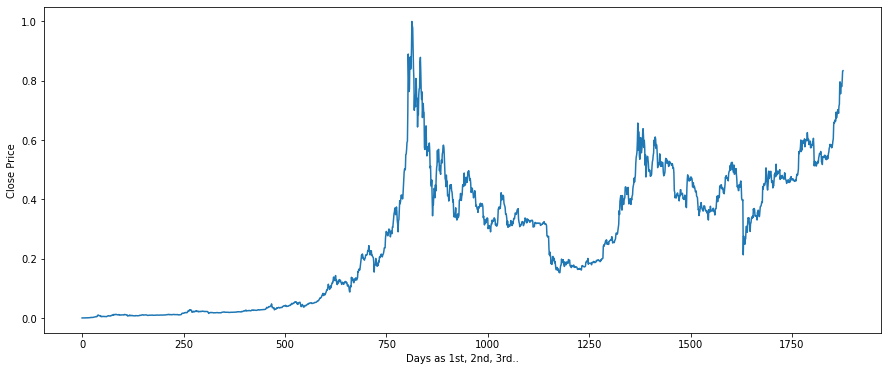

In [ ]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Close Price")
plt.show()

# Creating X_train and y_train from Train data

In [ ]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1827, 50)
Shape of y_train before reshape : (1827,)


# Reshape

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (1827, 50, 1)
Shape of y_train after reshape : (1827, 1)


In [ ]:
X_train[0]

array([[9.88909202e-05],
       [6.31659281e-05],
       [0.00000000e+00],
       [3.51036879e-04],
       [1.92086552e-04],
       [1.68787644e-04],
       [2.49039438e-04],
       [2.43861903e-04],
       [3.30326739e-04],
       [2.73891606e-04],
       [3.91421653e-04],
       [7.14499842e-04],
       [5.25002058e-04],
       [5.12575974e-04],
       [5.75224148e-04],
       [6.58064710e-04],
       [7.68346207e-04],
       [6.77739343e-04],
       [9.04515380e-04],
       [1.03706028e-03],
       [1.11679432e-03],
       [1.58432574e-03],
       [2.10311475e-03],
       [1.67441485e-03],
       [1.65991775e-03],
       [1.99645753e-03],
       [1.81627931e-03],
       [2.25792305e-03],
       [2.40807157e-03],
       [2.69749578e-03],
       [2.71820592e-03],
       [2.90097291e-03],
       [3.27323768e-03],
       [3.81584336e-03],
       [4.31340448e-03],
       [5.16252024e-03],
       [4.37191063e-03],
       [5.07864417e-03],
       [7.18072342e-03],
       [9.77052647e-03],


In [ ]:
y_train[0]

array([0.00519514])

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )
regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )
# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )
regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])
batch_size
# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
58/58 [==============================] - 9s 53ms/step - loss: 0.3529 - accuracy: 5.4735e-04
Epoch 2/50
58/58 [==============================] - 3s 51ms/step - loss: 0.1915 - accuracy: 5.4735e-04
Epoch 3/50
58/58 [==============================] - 3s 54ms/step - loss: 0.1131 - accuracy: 0.0000e+00
Epoch 4/50
58/58 [==============================] - 3s 52ms/step - loss: 0.0785 - accuracy: 5.4735e-04
Epoch 5/50
58/58 [==============================] - 3s 52ms/step - loss: 0.0563 - accuracy: 0.0000e+00
Epoch 6/50
58/58 [==============================] - 3s 51ms/step - loss: 0.0442 - accuracy: 0.0000e+00
Epoch 7/50
58/58 [==============================] - 3s 51ms/step - loss: 0.0357 - accuracy: 5.4735e-04
Epoch 8/50
58/58 [==============================] - 3s 51ms/step - loss: 0.0297 - accuracy: 5.4735e-04
Epoch 9/50
58/58 [==============================] - 3s 56ms/step - loss: 0.0247 - accuracy: 5.4735e-04
Epoch 10/50
58/58 [==============================] - 3s 51ms/step - loss:

In [ ]:
# Evaluating Model

In [ ]:
# Losses
history.history["loss"]


[0.35285064578056335,
 0.19154058396816254,
 0.11306887120008469,
 0.078488290309906,
 0.056307222694158554,
 0.044174909591674805,
 0.035710062831640244,
 0.0297495536506176,
 0.02465425617992878,
 0.021610351279377937,
 0.018947888165712357,
 0.016405567526817322,
 0.016867637634277344,
 0.01246614009141922,
 0.010402170941233635,
 0.01016213744878769,
 0.009488928131759167,
 0.00755694042891264,
 0.007181605324149132,
 0.007820959202945232,
 0.006708567496389151,
 0.005930738989263773,
 0.005583356134593487,
 0.0056582228280603886,
 0.004831651225686073,
 0.00427543418481946,
 0.004365106578916311,
 0.004138790536671877,
 0.003734803991392255,
 0.0034814251121133566,
 0.00356082571670413,
 0.0036920495331287384,
 0.0031780588906258345,
 0.00302174873650074,
 0.0027860987465828657,
 0.0028451571706682444,
 0.002833582693710923,
 0.0026202525477856398,
 0.0023926743306219578,
 0.002431288594380021,
 0.002418816089630127,
 0.002343134256079793,
 0.0022005669306963682,
 0.00236757029779

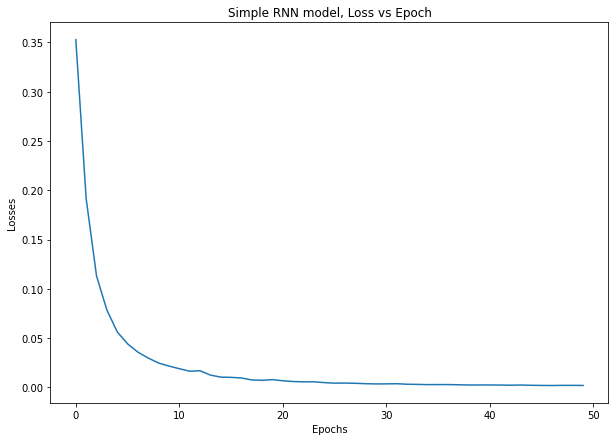

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

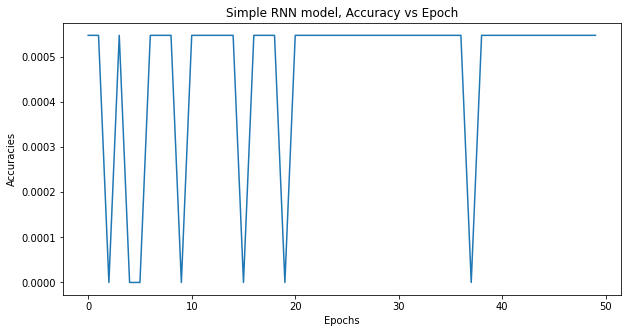

In [ ]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

Model Prediction for train data


In [ ]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

58/58 [==============================] - 1s 15ms/step


(1827, 1)

In [ ]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(1827, 1)

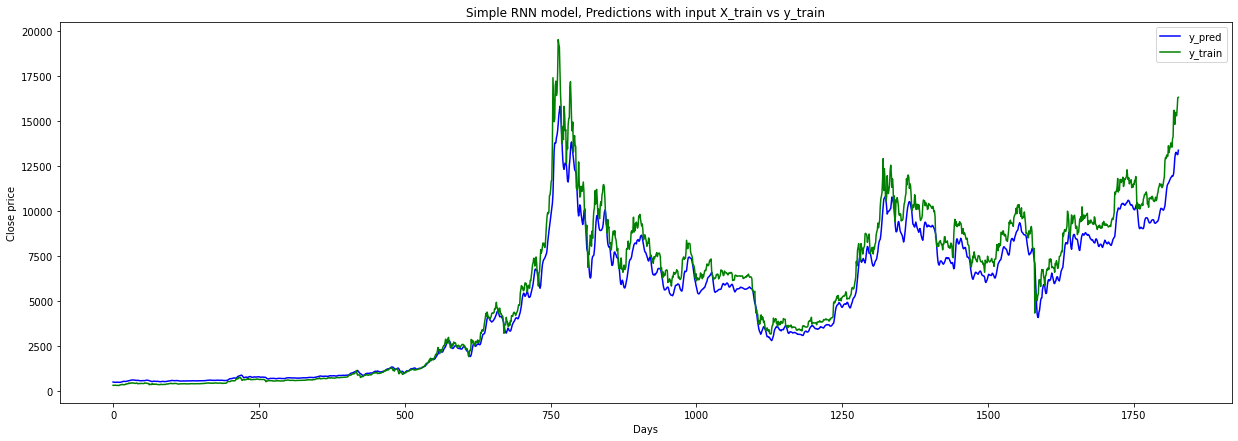

In [ ]:
# visualisation
plt.figure(figsize = (21,7))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

Creating Test Dataset from Validation Data



In [ ]:
# Converting array and scaling
dataset_validation = validation_data.close.values  # getting "close" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)


Shape of scaled validation dataset : (805, 1)


In [ ]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

In [ ]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (755, 50)
Shape of y_test before reshape : (755,)


Reshape

In [208]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array
socure=65.268

In [ ]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (755, 50, 1)
Shape of y_test after reshape : (755, 1)


Evaluating with Validation Data

In [ ]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

24/24 [==============================] - 0s 14ms/step
Shape of y_pred_of_test : (755, 1)


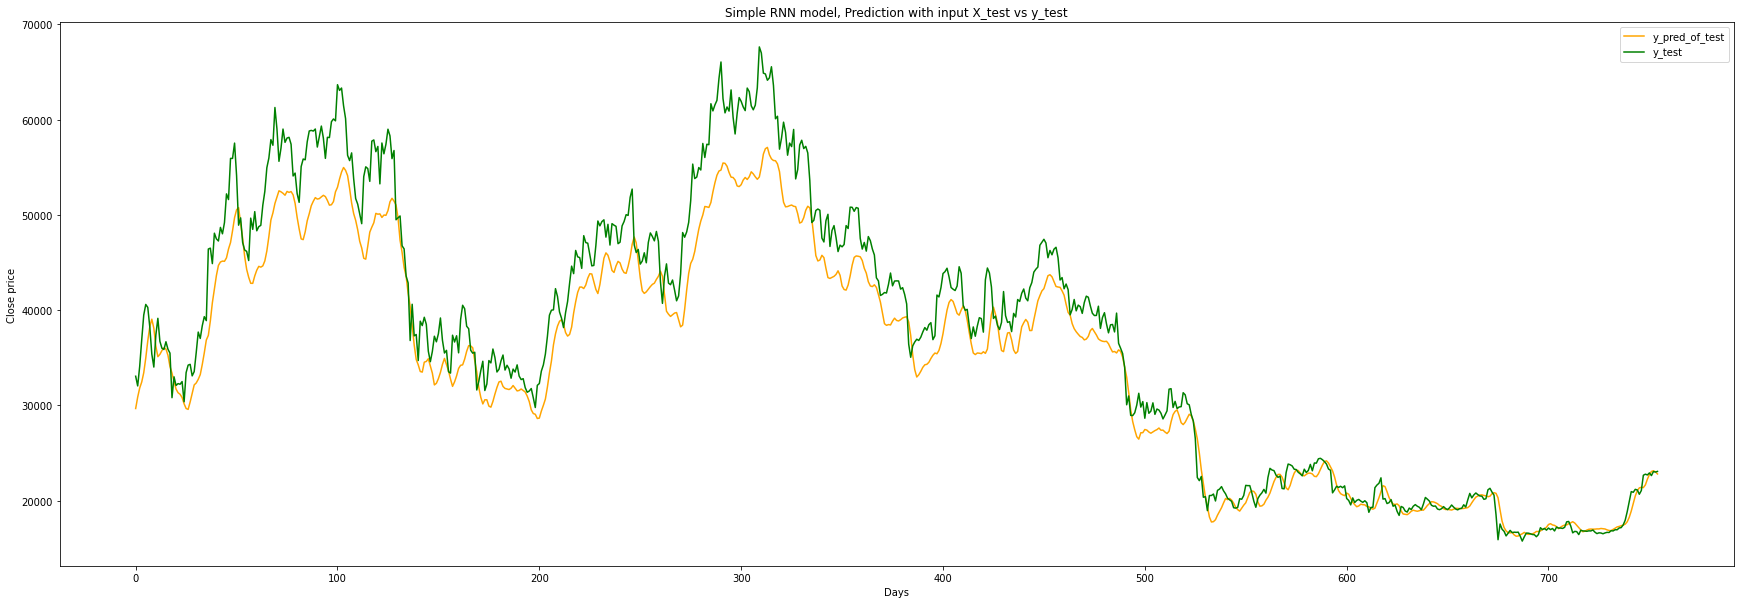

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

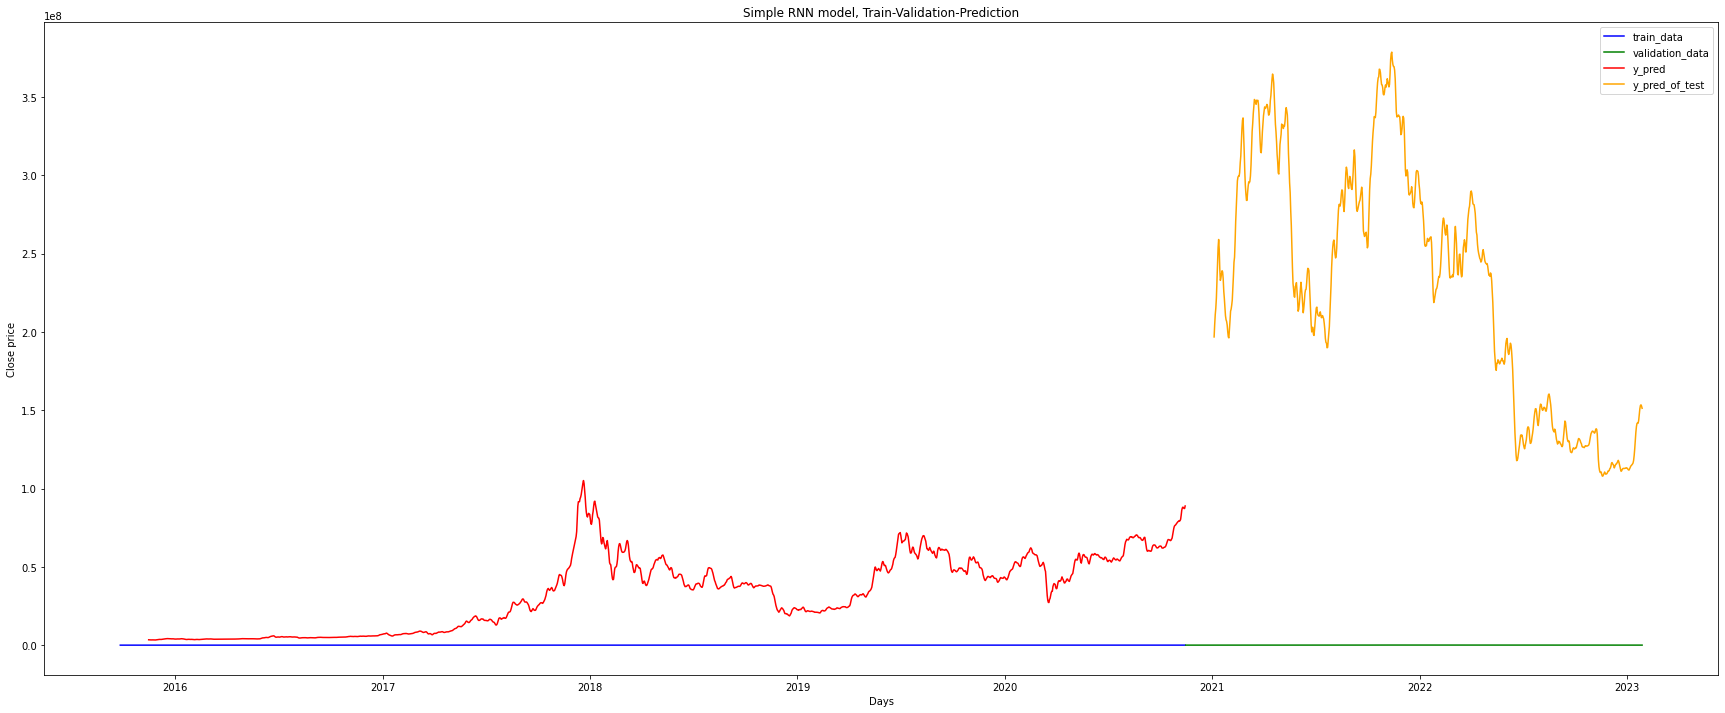

In [201]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.timestamp, train_data.close, label = "train_data", color = "b")
plt.plot(validation_data.timestamp, validation_data.close, label = "validation_data", color = "g")
plt.plot(train_data.timestamp.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.timestamp.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

Creating LSTM Model

In [ ]:
y_train = scaler.fit_transform(y_train)

In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
183/183 [==============================] - 16s 49ms/step - loss: 0.0052 - accuracy: 5.4735e-04
Epoch 2/10
183/183 [==============================] - 9s 49ms/step - loss: 0.0012 - accuracy: 0.0011
Epoch 3/10
183/183 [==============================] - 11s 58ms/step - loss: 0.0011 - accuracy: 0.0011
Epoch 4/10
183/183 [==============================] - 14s 79ms/step - loss: 8.1655e-04 - accuracy: 0.0011
Epoch 5/10
183/183 [==============================] - 9s 48ms/step - loss: 7.3679e-04 - accuracy: 0.0011
Epoch 6/10
183/183 [==============================] - 9s 49ms/step - loss: 8.0647e-04 - accuracy: 0.0011
Epoch 7/10
183/183 [==============================] - 13s 74ms/step - loss: 6.6516e-04 - accuracy: 0.0011
Epoch 8/10
183/183 [==============================] - 11s 59ms/step - loss: 5.8424e-04 - accuracy: 0.0011
Epoch 9/10
183/183 [==============================] - 9s 49ms/step - loss: 6.1292e-04 - accuracy: 0.0011
Epoch 10/10
183/183 [==============================] - 13s

Evaluating LSTM Model

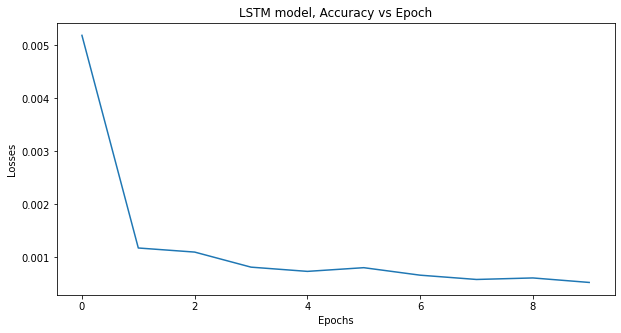

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

24/24 [==============================] - 1s 19ms/step


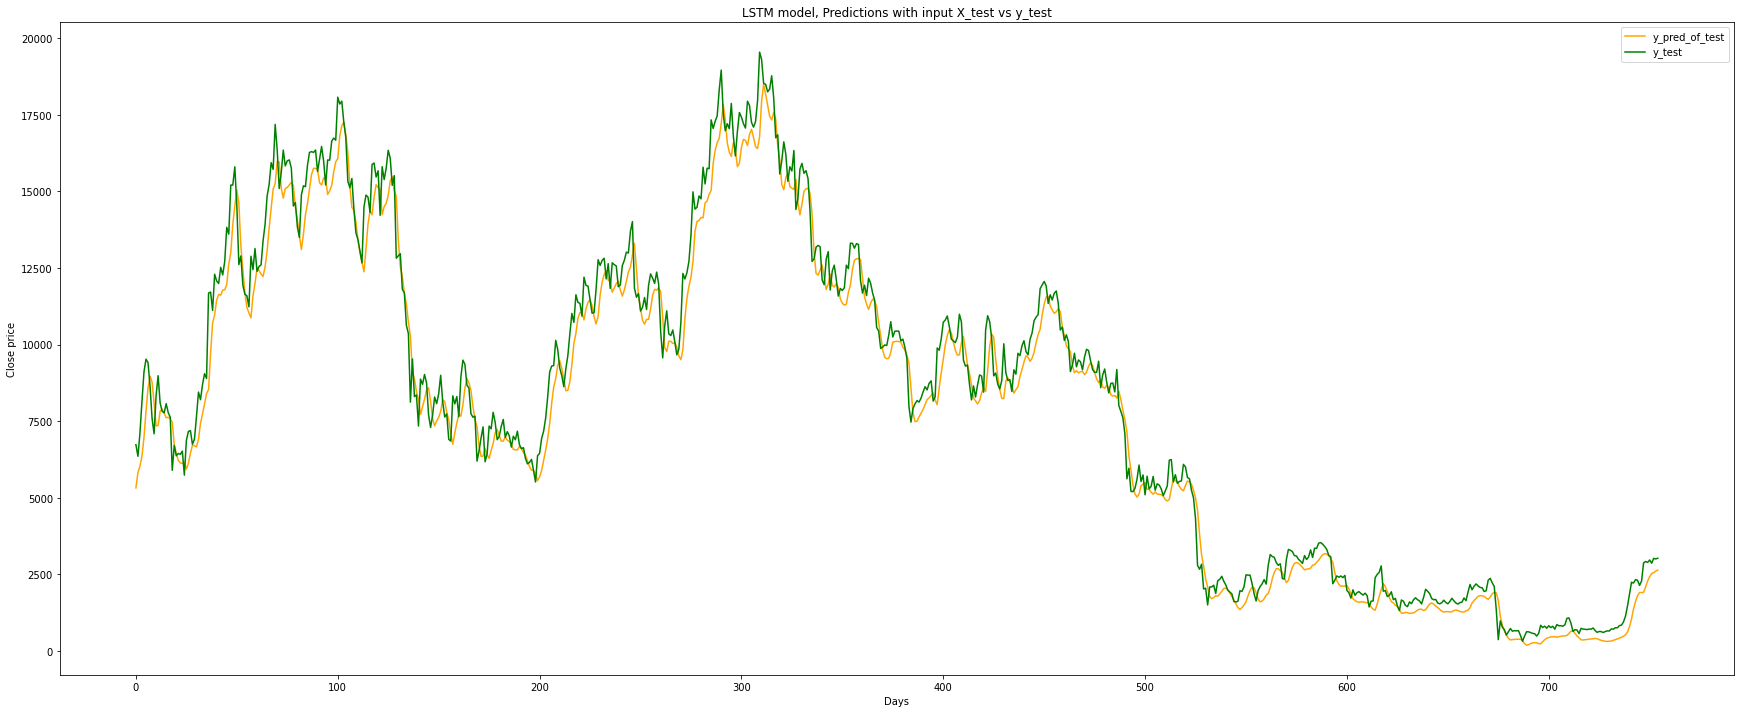

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

Future price prediction

In [ ]:
data.iloc[-1]

timestamp          2023-01-28 00:00:00+00:00
symbol                                XBTUSD
open                                 23004.0
high                                 23499.5
low                                  22525.0
close                                23068.0
trades                                107087
volume                             709014500
vwap                              23046.9974
lastSize                                 100
turnover                       3076389320783
homeNotional                    30763.893208
foreignNotional                  709014500.0
Name: 2681, dtype: object

In [ ]:
X_input = data.iloc[-time_step:].close.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.10311299],
        [0.10364061],
        [0.09753524],
        [0.11517299],
        [0.20200497],
        [0.20758272],
        [0.13823773],
        [0.027738  ],
        [0.05117962],
        [0.04673249],
        [0.        ],
        [0.06889274],
        [0.05834024],
        [0.05653124],
        [0.05215949],
        [0.05939549],
        [0.05796337],
        [0.07318912],
        [0.03881812],
        [0.01552725],
        [0.02796412],
        [0.02525062],
        [0.01319062],
        [0.02645662],
        [0.03550162],
        [0.03339112],
        [0.06150599],
        [0.05781262],
        [0.07725937],
        [0.07620412],
        [0.10499736],
        [0.11049974],
        [0.15195598],
        [0.22740635],
        [0.3622522 ],
        [0.52543906],
        [0.68041004],
        [0.67000829],
        [0.71628854],
        [0.70611291],
        [0.6386523 ],
        [0.69782166],
        [0.93924776],
        [0.95635788],
        [0.94414713],
        [0

In [ ]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Close price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Close price prediction for 3/18/2017 :", LSTM_prediction[0,0])
simple_RNN_prediction

1/1 [==============================] - 0s 59ms/step
Simple RNN, Close price prediction for 3/18/2017      : 21759.346
LSTM prediction, Close price prediction for 3/18/2017 : 22692.852


array([[21759.346]], dtype=float32)

In [ ]:
from sklearn.metrics import r2_score


In [ ]:
score = r2_score(y_test, y_pred_of_test)

In [ ]:
y_test

array([[0.3335935 ],
       [0.31397489],
       [0.35373245],
       [0.40722111],
       [0.45740468],
       [0.4788541 ],
       [0.47290878],
       [0.43308376],
       [0.37844843],
       [0.35216181],
       [0.41700151],
       [0.45078484],
       [0.40435926],
       [0.39033909],
       [0.38769886],
       [0.40339568],
       [0.38823847],
       [0.38035633],
       [0.29019358],
       [0.33244683],
       [0.31485175],
       [0.31871573],
       [0.31737635],
       [0.32275316],
       [0.28191638],
       [0.34098421],
       [0.35609324],
       [0.35764461],
       [0.33433546],
       [0.3429981 ],
       [0.38142591],
       [0.42296611],
       [0.41005406],
       [0.43571435],
       [0.45415739],
       [0.44610181],
       [0.59096734],
       [0.59281743],
       [0.56149125],
       [0.62304512],
       [0.61153991],
       [0.60730976],
       [0.63477197],
       [0.62182137],
       [0.64458127],
       [0.70258916],
       [0.69109357],
       [0.774

In [ ]:
y_pred_of_test


array([[29672.03 ],
       [30867.518],
       [31825.84 ],
       [32454.596],
       [33429.19 ],
       [34962.895],
       [36775.586],
       [38276.47 ],
       [39052.83 ],
       [38109.875],
       [36207.523],
       [35118.016],
       [35356.34 ],
       [35752.094],
       [36044.48 ],
       [35926.863],
       [35261.18 ],
       [34086.848],
       [33388.887],
       [32513.408],
       [31722.68 ],
       [31332.834],
       [31171.365],
       [30827.057],
       [30170.32 ],
       [29671.375],
       [29581.172],
       [30364.602],
       [31240.848],
       [32150.426],
       [32354.08 ],
       [32734.842],
       [33231.85 ],
       [34299.207],
       [35520.145],
       [36863.094],
       [37350.19 ],
       [38874.5  ],
       [40779.24 ],
       [42176.312],
       [43634.04 ],
       [44698.926],
       [45057.48 ],
       [45151.246],
       [45132.105],
       [45495.41 ],
       [46423.832],
       [47099.242],
       [48340.844],
       [49715.652],


In [ ]:
y_pred = scaler.inverse_transform(y_pred)

In [ ]:
y_pred

array([[ 3427287. ],
       [ 3389535.8],
       [ 3332200. ],
       ...,
       [87297352. ],
       [87275632. ],
       [88880640. ]], dtype=float32)

In [ ]:
y_pred_of_test 

array([[29672.03 ],
       [30867.518],
       [31825.84 ],
       [32454.596],
       [33429.19 ],
       [34962.895],
       [36775.586],
       [38276.47 ],
       [39052.83 ],
       [38109.875],
       [36207.523],
       [35118.016],
       [35356.34 ],
       [35752.094],
       [36044.48 ],
       [35926.863],
       [35261.18 ],
       [34086.848],
       [33388.887],
       [32513.408],
       [31722.68 ],
       [31332.834],
       [31171.365],
       [30827.057],
       [30170.32 ],
       [29671.375],
       [29581.172],
       [30364.602],
       [31240.848],
       [32150.426],
       [32354.08 ],
       [32734.842],
       [33231.85 ],
       [34299.207],
       [35520.145],
       [36863.094],
       [37350.19 ],
       [38874.5  ],
       [40779.24 ],
       [42176.312],
       [43634.04 ],
       [44698.926],
       [45057.48 ],
       [45151.246],
       [45132.105],
       [45495.41 ],
       [46423.832],
       [47099.242],
       [48340.844],
       [49715.652],


In [ ]:
y_test = scaler.inverse_transform(y_test)

In [ ]:
y_test

array([[18647.3924927 ],
       [18517.25242583],
       [18780.98421164],
       [19135.80126037],
       [19468.69392652],
       [19610.97869511],
       [19571.54037426],
       [19307.36115206],
       [18944.93768489],
       [18770.56533595],
       [19200.67953536],
       [19424.78124187],
       [19116.81717399],
       [19023.8143266 ],
       [19006.30038833],
       [19110.42522572],
       [19009.87987936],
       [18957.59374247],
       [18359.49914241],
       [18639.78607425],
       [18523.06909876],
       [18548.70081134],
       [18539.81600324],
       [18575.48307461],
       [18304.59230673],
       [18696.41873597],
       [18796.64448492],
       [18806.93552164],
       [18652.31429287],
       [18709.77790786],
       [18964.68880506],
       [19240.24569518],
       [19154.5935883 ],
       [19324.81117085],
       [19447.15306083],
       [19393.71637325],
       [20354.68187687],
       [20366.95441756],
       [20159.15217915],
       [20567.46983494],


In [ ]:
y_pred_of_test  = scaler.inverse_transform(y_pred_of_test)

In [ ]:
y_pred_of_test 

array([[1.96845840e+08],
       [2.04776112e+08],
       [2.11133136e+08],
       [2.15303984e+08],
       [2.21768976e+08],
       [2.31942784e+08],
       [2.43967280e+08],
       [2.53923376e+08],
       [2.59073360e+08],
       [2.52818288e+08],
       [2.40199040e+08],
       [2.32971792e+08],
       [2.34552704e+08],
       [2.37177936e+08],
       [2.39117488e+08],
       [2.38337280e+08],
       [2.33921456e+08],
       [2.26131536e+08],
       [2.21501616e+08],
       [2.15694128e+08],
       [2.10448816e+08],
       [2.07862784e+08],
       [2.06791680e+08],
       [2.04507712e+08],
       [2.00151248e+08],
       [1.96841488e+08],
       [1.96243136e+08],
       [2.01440016e+08],
       [2.07252592e+08],
       [2.13286272e+08],
       [2.14637216e+08],
       [2.17163008e+08],
       [2.20459920e+08],
       [2.27540224e+08],
       [2.35639312e+08],
       [2.44547760e+08],
       [2.47778928e+08],
       [2.57890432e+08],
       [2.70525504e+08],
       [2.79792992e+08],


In [206]:
socre = r2_score(y_test, y_pred_of_test)

In [209]:
socure

65.268